# IBM QAOA Data Analysis with Stochastic Benchmark

This notebook processes IBM QAOA experimental data and runs it through the stochastic benchmark framework. We'll convert JSON results into the required format and perform comprehensive analysis.

## 1. Import Required Libraries

Import necessary libraries including json, os, subprocess, and pathlib for file operations and script execution.

In [1]:
import json
import os
import glob
import sys
import re
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Dict, List, Any
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# Set up matplotlib style
plt.style.use('../../src/ws.mplstyle')

# Add stochastic-benchmark src to path
sys.path.append('../../src')

# Import stochastic benchmark modules
import stochastic_benchmark
import bootstrap
import success_metrics
import interpolate
from interpolate import Interpolate
import stats
import training

print("Libraries imported successfully!")

%load_ext autoreload
%autoreload 2

Libraries imported successfully!


## 2. Load and Parse JSON Configuration

Read and parse the JSON configuration file to extract parameters, file paths, and execution settings.

In [2]:
# Load the JSON data
cwd = os.getcwd() 
print(cwd)
json_file_path = os.path.join(cwd, "R3R/*.json")

# Use glob to get a list of all .json file paths
json_files = glob.glob(json_file_path)
print(json_files)
all_qaoa_data = []

for json_file in json_files:
    with open(json_file, 'r') as f:
        qaoa_data = json.load(f)
        all_qaoa_data.append(qaoa_data)

    trial_keys = [key for key in qaoa_data if key.isdigit()]
    num_trials = len(trial_keys)

    if num_trials > 0:
        print(f"\nLoaded data for {num_trials} QAOA trials")

        for trial_key in trial_keys:
            print(f"\n--- Trial {trial_key} ---")
            trial_data = qaoa_data[trial_key]
            
            # Check if the trial has a 'trainer' and a 'trainer_name' i.e. classical optimizer
            if 'trainer' in trial_data and 'trainer_name' in trial_data['trainer']:
                trainer_name = trial_data['trainer']['trainer_name']
                print(f"Trainer: {trainer_name}")

            # Print all other key-value pairs for the trial
            for key, value in trial_data.items():
                if key == 'trainer':
                    continue
                
                if isinstance(value, list) and len(value) > 3:
                    print(f"{key}: [{value[0]}, {value[1]}, ..., {value[-1]}] (length: {len(value)})")
                else:
                    print(f"{key}: {value}")
    else:
        print("Error: No QAOA trials found in the JSON data.")


/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA
['/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250901_165018_000N10R3R_MC_FA_SV_noOpt_2.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250901_165018_000N10R3R_MC_FA_SV_noOpt_4.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250901_165018_000N10R3R_MC_FA_SV_noOpt_6.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250901_165018_000N10R3R_MC_FA_SV_noOpt_8.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250913_170712_001N10R3R_MC_FA_SV_noOpt_1.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250913_171721_002N10R3R_MC_FA_SV_noOpt_1.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/IBM_QAOA/R3R/20250913_172924_003N10R3R_MC_FA_SV_noOpt_1.json', '/mnt/c/Users/rames102/Desktop/stochastic-benchmark/examples/I

## 3. File Processing Functions

Create utility functions to process and validate input files, handle different file formats, and prepare data for script execution.

In [3]:
@dataclass
class QAOAResult:
    """Data class to hold QAOA optimization results"""
    trial_id: int
    optimized_params: List[float]
    train_duration: float
    energy: float
    approximation_ratio: float
    trainer_name: str
    method: str = None
    success: bool = False
    energy_history: List[float] = None
    parameter_history: List[List[float]] = None
    x0: List[float] = None


def parse_qaoa_trial(trial_id: str, trial_data: Dict[str, Any]) -> QAOAResult:
    """
    Parse a single QAOA trial entry from JSON-formatted experiment data.

    This function converts a JSON record corresponding to one QAOA optimization trial
    into a structured `QAOAResult` object. It performs type and value normalization,
    ensuring robustness to missing or string-encoded numeric and boolean values.

    Parameters
    ----------
    trial_id : str
        Unique identifier (string key) of the QAOA trial within the JSON dataset.
    trial_data : dict
        Dictionary containing trial attributes and performance metrics.
        Expected keys include:
        - `'energy'` : float or str
            Final energy value of the trial (may be `"NA"`).
        - `'success'` : bool or str
            Indicates whether the optimization converged successfully.
        - `'trainer'` : dict, optional
            Trainer metadata containing fields such as `'method'` and `'trainer_name'`.
        - `'approximation ratio'` : float or str
            Final approximation ratio for the trial.
        - `'optimized_params'` : list of float
            Final optimized QAOA parameters (e.g., γ, β values).
        - `'train_duration'` : float
            Time (in seconds) required to complete the trial.
        - `'energy_history'` : list of float, optional
            Energy values observed during optimization.
        - `'parameter_history'` : list of list of float, optional
            Parameter values across optimization iterations.
        - `'x0'` : list of float, optional
            Initial parameter vector used for the trial.

    Returns
    -------
    QAOAResult
        Structured representation of the QAOA trial, containing all relevant metrics
        and histories in standardized formats.

    Notes
    -----
    - Handles `"NA"` string placeholders by converting them to `np.nan`.
    - Converts `'success'` field to a boolean even if stored as a string.
    - Missing or malformed trainer information is safely defaulted to `'Unknown'`.

    Examples
    --------
    >>> trial_json = {
    ...     "energy": -1.2345,
    ...     "approximation ratio": 0.875,
    ...     "train_duration": 0.032,
    ...     "optimized_params": [0.45, 1.22],
    ...     "trainer": {"trainer_name": "Adam", "method": "gradient"},
    ...     "success": "True"
    ... }
    >>> result = parse_qaoa_trial("12", trial_json)
    >>> result.energy
    -1.2345
    >>> result.success
    True
    """
    # Extract energy - handle "NA" values
    energy = trial_data.get('energy', np.nan)
    if energy == "NA":
        energy = np.nan
        
    # Extract success - handle string boolean
    success_str = trial_data.get('success', 'False')
    success = success_str.lower() == 'true' if isinstance(success_str, str) else bool(success_str)
    
    # Extract trainer information
    trainer_info = trial_data.get('trainer', {})
    method = None
    if isinstance(trainer_info, dict):
        method = trainer_info.get('method', None)

    # Extract approximation_ratio
    approximation_ratio = trial_data.get('approximation ratio', np.nan)
    if approximation_ratio == "NA":
        approximation_ratio = np.nan
    
    return QAOAResult(
        trial_id=int(trial_id),
        optimized_params=trial_data.get('optimized_params', []),
        train_duration=trial_data.get('train_duration', 0.0),
        energy=energy,
        approximation_ratio=approximation_ratio,
        trainer_name=trainer_info.get('trainer_name', 'Unknown') if isinstance(trainer_info, dict) else str(trainer_info),
        method=method,
        success=success,
        energy_history=trial_data.get('energy_history', []),
        parameter_history=trial_data.get('parameter_history', []),
        x0=trial_data.get('x0', [])
    )


def load_qaoa_results(data: Dict[str, Any]) -> List[QAOAResult]:
    """
        Load and parse all QAOA trial results from a JSON-like dictionary.

        This function iterates over the provided JSON data, extracts valid QAOA trial entries 
        (those with numeric keys), and parses each trial using `parse_qaoa_trial`. Trials 
        associated with the 'RandomPoint' trainer are skipped, as they do not contain 
        meaningful optimization results.

        Parameters
        ----------
        data : Dict[str, Any]
            Dictionary containing QAOA trial data loaded from a JSON file. Each key typically 
            represents a trial index (as a string), and each value contains metadata such as 
            training information, energies, and parameter histories.

        Returns
        -------
        List[QAOAResult]
            A list of `QAOAResult` objects containing parsed trial results, excluding 
            uninformative trials (e.g., 'RandomPoint').
        """
    results = []

    # 1. Identify only the keys that are numerical trial indices (e.g., "0", "1", "2")
    trial_keys = [key for key in data if key.isdigit()]

    for trial_id in trial_keys:
        trial_data = data[trial_id]
        trainer_name = 'Unknown'
        trainer_info = trial_data.get('trainer')
        if isinstance(trainer_info, dict):
            trainer_name = trainer_info.get('trainer_name')
        elif trainer_info is not None:
             # This makes it generally robust
            trainer_name = str(trainer_info) 

        if trainer_name == 'RandomPoint': # No meaningful optimization data
            continue            
        result = parse_qaoa_trial(trial_id, trial_data)
        results.append(result)
    
    return results


In [4]:

all_qaoa_results = []

for qaoa_data in all_qaoa_data:
    # Load and parse the QAOA results
    qaoa_results = load_qaoa_results(qaoa_data)
    print(f"\n Parsed {len(qaoa_results)} QAOA optimization trials")
    all_qaoa_results.append(qaoa_results)

    # Display summary statistics
    energies = [r.energy for r in qaoa_results if not np.isnan(r.energy)]
    approximation_ratios = [r.approximation_ratio for r in qaoa_results if not np.isnan(r.approximation_ratio)]
    durations = [r.train_duration for r in qaoa_results]
    successes = [r.success for r in qaoa_results]

    print(f"Summary Statistics:")
    print(f"Energy range: {min(energies):.4f} to {max(energies):.4f}")
    print(f"Approximation ratio range: {min(approximation_ratios):.4f} to {max(approximation_ratios):.4f}")
    print(f"Training duration range: {min(durations):.4f} to {max(durations):.4f} seconds")
    print(f"Success rate: {sum(successes)}/{len(successes)} ({100*sum(successes)/len(successes):.1f}%)")


 Parsed 1 QAOA optimization trials
Summary Statistics:
Energy range: 3.3287 to 3.3287
Approximation ratio range: 0.7559 to 0.7559
Training duration range: 0.0080 to 0.0080 seconds
Success rate: 0/1 (0.0%)

 Parsed 1 QAOA optimization trials
Summary Statistics:
Energy range: 4.3257 to 4.3257
Approximation ratio range: 0.8169 to 0.8169
Training duration range: 0.0113 to 0.0113 seconds
Success rate: 0/1 (0.0%)

 Parsed 1 QAOA optimization trials
Summary Statistics:
Energy range: 4.9248 to 4.9248
Approximation ratio range: 0.8499 to 0.8499
Training duration range: 0.0146 to 0.0146 seconds
Success rate: 0/1 (0.0%)

 Parsed 1 QAOA optimization trials
Summary Statistics:
Energy range: 5.2516 to 5.2516
Approximation ratio range: 0.8674 to 0.8674
Training duration range: 0.0183 to 0.0183 seconds
Success rate: 0/1 (0.0%)

 Parsed 1 QAOA optimization trials
Summary Statistics:
Energy range: 2.2201 to 2.2201
Approximation ratio range: 0.6925 to 0.6925
Training duration range: 0.0468 to 0.0468 sec

## 4. Repository Code Execution Engine

Build functions to discover repository structure, identify executable scripts, and map JSON data to code parameters.

In [5]:
def convert_to_dataframe(results: List[QAOAResult], instance_id: int = 1, circuit_depth: int = None) -> pd.DataFrame:
    """
    Convert a list of QAOA result objects into a standardized pandas DataFrame
    compatible with the stochastic-benchmark framework.

    This function extracts key metrics such as energy, approximation ratio, runtime, 
    and optimized QAOA parameters (`gamma`, `beta`, etc.) from each `QAOAResult` object.
    The resulting DataFrame is formatted to align with stochastic benchmarking workflows, 
    allowing downstream bootstrapping and performance analysis.

    Parameters
    ----------
    results : list of QAOAResult
        List of QAOA result objects containing trial-level outcomes.
        Each object must define the following attributes:
        - `optimized_params` (list of float)
        - `trial_id` (int)
        - `energy` (float)
        - `approximation_ratio` (float)
        - `train_duration` (float)
        - `trainer_name` (str)
        - `method` (str or None)
        - `success` (bool)
        - `energy_history` (list of float or None)
    instance_id : int, optional
        Unique identifier for the problem instance (default is 1).
    circuit_depth : int, optional
        Depth of the QAOA circuit corresponding to the result set.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with one row per QAOA trial containing:
        - `trial_id`, `instance`, `circuit_depth`
        - `Energy`, `Approximation_Ratio`, `MeanTime`
        - `trainer`, `method`, `success`, `n_iterations`, `count`
        - Variational parameters (`gamma`, `beta`, etc.)
        - `GTMinEnergy` (ground truth minimum energy placeholder)

    Notes
    -----
    - Missing or NaN energy values are replaced with `-999` to mark invalid trials.
    - The ground truth minimum energy (`GTMinEnergy`) is approximated as the 
      minimum valid energy in the dataset.
    - Additional parameters beyond `gamma` and `beta` are automatically labeled 
      as `param_2`, `param_3`, etc.

    Examples
    --------
    >>> df = convert_to_dataframe(qaoa_results, instance_id=3, circuit_depth=2)
    >>> print(df.head())
       trial_id  instance  circuit_depth  Energy  Approximation_Ratio  ...
             1         3              2  -1.2345                0.875
    """
    data_rows = []
    
    for result in results:
        # Extract parameter values
        params = result.optimized_params
        param_dict = {}
        if len(params) >= 1:
            param_dict['gamma'] = params[0]
        if len(params) >= 2:
            param_dict['beta'] = params[1]
        for i, param in enumerate(params[2:], start=2):
            param_dict[f'param_{i}'] = param
            
        # Assemble row data
        row = {
            'trial_id': result.trial_id,
            'instance': instance_id,
            'circuit_depth': circuit_depth,
            'Energy': result.energy if not np.isnan(result.energy) else -999,
            'Approximation_Ratio': result.approximation_ratio if not np.isnan(result.approximation_ratio) else -998,
            'MeanTime': result.train_duration,
            'trainer': result.trainer_name,
            'method': result.method or 'Unknown',
            'success': result.success,
            'n_iterations': len(result.energy_history) if result.energy_history else 0,
            'count': 1,
            **param_dict
        }
        data_rows.append(row)
    
    df = pd.DataFrame(data_rows)

    # Approximate GTMinEnergy (ground truth minimum energy)
    valid_energies = df[df['Energy'] != -999]['Energy']
    df['GTMinEnergy'] = valid_energies.min() if len(valid_energies) > 0 else -1.0
    
    # Enforce proper dtypes
    df = df.astype({
        'instance': int,
        'circuit_depth': int,
        'gamma': float,
        'beta': float,
        'Energy': float,
        'Approximation_Ratio': float,
        'MeanTime': float,
        'count': int
    })
    
    return df


def prepare_stochastic_benchmark_data(df: pd.DataFrame, instance_id: int, circuit_depth: int, output_dir: str = 'exp_raw'):
    """
    Prepare and save QAOA benchmarking data in a format compatible with the 
    stochastic-benchmark framework.

    This function cleans the provided DataFrame, ensures consistency across 
    key metrics, and saves the processed data as a pickle file. It is typically
    used as a post-processing step after converting raw QAOA results into a 
    DataFrame using `convert_to_dataframe()`.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing QAOA results, typically produced by 
        `convert_to_dataframe()`. Must include:
        - 'Energy'
        - 'Approximation_Ratio'
        - 'MeanTime'
        - 'gamma', 'beta'
    instance_id : int
        Identifier for the QAOA problem instance.
    circuit_depth : int
        QAOA circuit depth corresponding to this result set.
    output_dir : str, optional
        Directory to store the processed pickle file. Default is `'exp_raw'`.

    Returns
    -------
    str
        Path to the saved pickle file containing cleaned and structured benchmark data.

    Notes
    -----
    - Rows with invalid energy values (`Energy == -999`) are removed.
    - The minimum energy across all valid trials is assigned as `GTMinEnergy` for consistency.
    - Output filename follows the format:
      `'raw_results_inst={instance_id}_{circuit_depth}.pkl'`
    - Designed for single-instance data, but can be extended for batch processing.

    Examples
    --------
    >>> df = convert_to_dataframe(qaoa_results, instance_id=3, circuit_depth=2)
    >>> path = prepare_stochastic_benchmark_data(df, 3, 2)
    Original data: 50 rows, Valid data: 45 rows
    Saved instance 3 → exp_raw/raw_results_inst=3_2.pkl (45 trials)
    >>> print(path)
    'exp_raw/raw_results_inst=3_2.pkl'
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Filter out invalid energy rows
    df_clean = df[df['Energy'] != -999].copy()
    
    print(f"Original data: {len(df)} rows, Valid data: {len(df_clean)} rows")
    
    df_final = df_clean.copy()
    if len(df_final) > 0:
        df_final['GTMinEnergy'] = df_final['Energy'].min()
    
    # Save DataFrame to pickle
    output_file = os.path.join(output_dir, f'raw_results_inst={instance_id}_{circuit_depth}.pkl')
    df_final.to_pickle(output_file)
    print(f"Saved instance {instance_id} → {output_file} ({len(df_clean)} trials)")
    
    # Print summary statistics
    if len(df_final) > 0:
        print("\nData Summary:")
        print(f"  Energy range: [{df_final['Energy'].min():.4f}, {df_final['Energy'].max():.4f}]")
        print(f"  Approximation Ratio range: [{df_final['Approximation_Ratio'].min():.4f}, {df_final['Approximation_Ratio'].max():.4f}]")
        print(f"  Time range: [{df_final['MeanTime'].min():.4f}, {df_final['MeanTime'].max():.4f}]")
        print(f"  Gamma range: [{df_final['gamma'].min():.4f}, {df_final['gamma'].max():.4f}]")
        print(f"  Beta range: [{df_final['beta'].min():.4f}, {df_final['beta'].max():.4f}]")
    
    return output_file

In [6]:
# Convert QAOA results to DataFrame
all_qaoa_df = []
all_data_files = []

for qaoa_results, json_file in zip(all_qaoa_results, json_files):
    
    # Extract filename
    filename = os.path.basename(json_file)
    parts = filename.split('_')
    
    # --- Extract instance ID (leading numeric part of third segment) ---
    instance_str = parts[2]  # e.g., '000N10R3R'
    match = re.match(r'(\d+)', instance_str)
    instance_id = match.group(1) if match else '0'  # keeps leading zeros as string
    
    # --- Extract circuit depth (last part before .json) ---
    depth_str = parts[-1].replace('.json', '')
    try:
        circuit_depth = int(depth_str)
    except ValueError:
        circuit_depth = None

    qaoa_df = convert_to_dataframe(qaoa_results, instance_id, circuit_depth)
    print(f"\nInstance {instance_id}: DataFrame shape {qaoa_df.shape}")
    print(f"\nColumns: {list(qaoa_df.columns)}")
    all_qaoa_df.append(qaoa_df)

# Check for valid data
    valid_count = len(qaoa_df[qaoa_df['Energy'] != -999])
    print(f"Valid energy values: {valid_count}/{len(qaoa_df)}")

    valid_count_1 = len(qaoa_df[qaoa_df['Approximation_Ratio'] != -998])
    print(f"Valid approximation ratio values: {valid_count_1}/{len(qaoa_df)}")

    # print(f"\nFirst few rows:")
    # display(qaoa_df.head())

    # Prepare data for stochastic benchmark
    data_file = prepare_stochastic_benchmark_data(qaoa_df, instance_id, circuit_depth)
    print(f"\nData prepared for stochastic benchmark analysis.")
    all_data_files.append(data_file)

print("\n All instances processed.")


# Aggregate into a single dataframe sorted by instance ID and circuit depth

agg_df = pd.concat(all_qaoa_df, ignore_index=True)

# Convert instance_id to integer if needed (strip leading zeros)
agg_df['instance'] = agg_df['instance'].astype(int)

# Sort by instance first, then circuit_depth
agg_df = agg_df.sort_values(by=['instance', 'circuit_depth']).reset_index(drop=True)

display(agg_df)



Instance 000: DataFrame shape (1, 16)

Columns: ['trial_id', 'instance', 'circuit_depth', 'Energy', 'Approximation_Ratio', 'MeanTime', 'trainer', 'method', 'success', 'n_iterations', 'count', 'gamma', 'beta', 'param_2', 'param_3', 'GTMinEnergy']
Valid energy values: 1/1
Valid approximation ratio values: 1/1
Original data: 1 rows, Valid data: 1 rows
Saved instance 000 → exp_raw/raw_results_inst=000_2.pkl (1 trials)

Data Summary:
  Energy range: [3.3287, 3.3287]
  Approximation Ratio range: [0.7559, 0.7559]
  Time range: [0.0080, 0.0080]
  Gamma range: [0.5551, 0.5551]
  Beta range: [0.2925, 0.2925]

Data prepared for stochastic benchmark analysis.

Instance 000: DataFrame shape (1, 20)

Columns: ['trial_id', 'instance', 'circuit_depth', 'Energy', 'Approximation_Ratio', 'MeanTime', 'trainer', 'method', 'success', 'n_iterations', 'count', 'gamma', 'beta', 'param_2', 'param_3', 'param_4', 'param_5', 'param_6', 'param_7', 'GTMinEnergy']
Valid energy values: 1/1
Valid approximation ratio v

,trial_id,instance,circuit_depth,Energy,Approximation_Ratio,MeanTime,trainer,method,success,n_iterations,...,param_6,param_7,param_8,param_9,param_10,param_11,param_12,param_13,param_14,param_15
0,0,0,2,3.328700,0.755906,0.007992,FixedAngleConjecture,Unknown,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,4,4.325682,0.816876,0.011300,FixedAngleConjecture,Unknown,False,0,...,0.987728,1.156314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,6,4.924784,0.849894,0.014616,FixedAngleConjecture,Unknown,False,0,...,0.331042,0.645031,0.730777,0.836583,1.009164,1.126100,NaN,NaN,NaN,NaN
3,0,0,8,5.251569,0.867407,0.018278,FixedAngleConjecture,Unknown,False,0,...,0.231324,0.122904,0.294606,0.586786,0.654410,0.707929,0.764574,0.86425,1.025666,1.116287
4,0,1,1,2.220106,0.692450,0.046794,FixedAngleConjecture,Unknown,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1,2,3.031728,0.755906,0.022882,FixedAngleConjecture,Unknown,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1,4,3.848708,0.816876,0.011348,FixedAngleConjecture,Unknown,False,0,...,0.987728,1.156314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,1,6,3.966997,0.849894,0.014928,FixedAngleConjecture,Unknown,False,0,...,0.331042,0.645031,0.730777,0.836583,1.009164,1.126100,NaN,NaN,NaN,NaN
8,0,1,8,4.051578,0.867407,0.018475,FixedAngleConjecture,Unknown,False,0,...,0.231324,0.122904,0.294606,0.586786,0.654410,0.707929,0.764574,0.86425,1.025666,1.116287
9,0,2,1,2.720090,0.692450,0.006758,FixedAngleConjecture,Unknown,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_83451/851139583.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(depths))  # tab10 gives 10 distinct colors


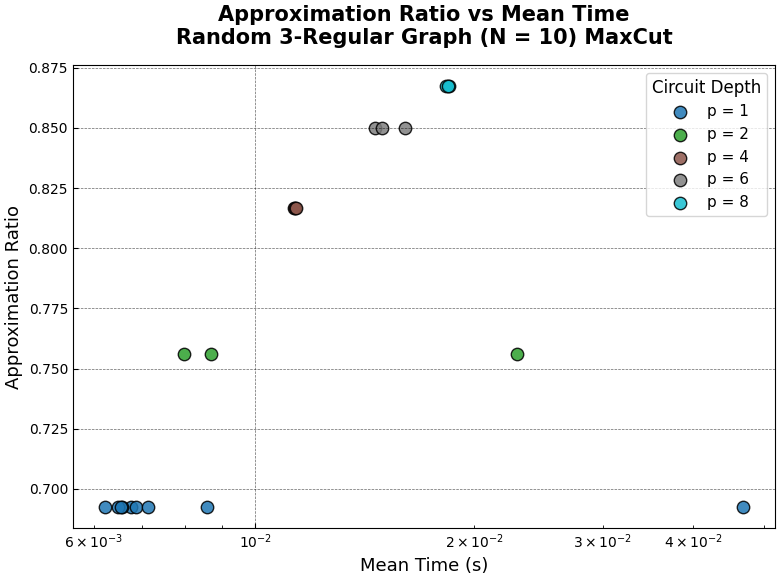

In [7]:
# === Consolidate QAOA results with depth info ===
plot_data = []

for file, qaoa_results in zip(json_files, all_qaoa_results):
    filename = os.path.basename(file)
    try:
        depth = int(filename.split('_')[-1].split('.')[0])
    except (IndexError, ValueError):
        depth = None

    for res in qaoa_results:
        if not np.isnan(res.energy):
            plot_data.append({
                'Approximation Ratio': res.approximation_ratio,
                'Mean Time (s)': res.train_duration,
                'Depth': depth
            })

plot_df = pd.DataFrame(plot_data)

# === Plot ===
if not plot_df.empty:
    plt.figure(figsize=(8, 6))
    depths = sorted(plot_df['Depth'].dropna().unique())

    # Use discrete colors for each depth
    cmap = cm.get_cmap('tab10', len(depths))  # tab10 gives 10 distinct colors
    depth_to_color = {d: cmap(i) for i, d in enumerate(depths)}

    # Scatter points for each depth separately for clear colors and legend
    for d in depths:
        df_d = plot_df[plot_df['Depth'] == d]
        plt.scatter(
            df_d['Mean Time (s)'],
            df_d['Approximation Ratio'],
            color=depth_to_color[d],
            s=80,
            edgecolor='k',
            alpha=0.85,
            label=f'p = {d}'
        )

    # === Formatting ===
    plt.xlabel('Mean Time (s)', fontsize=13)
    plt.ylabel('Approximation Ratio', fontsize=13)
    plt.xscale('log')
    plt.title(
        'Approximation Ratio vs Mean Time\nRandom 3-Regular Graph (N = 10) MaxCut',
        fontsize=15, fontweight='bold', pad=15
    )
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Circuit Depth', fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("No data available to plot.")

Create a Stochastic Benchmark Object

In [8]:
def setup_qaoa_benchmark():
    """
    Initialize and configure the stochastic benchmark object for QAOA experiments.

    This function sets up a `stochastic_benchmark` instance tailored for analyzing
    Quantum Approximate Optimization Algorithm (QAOA) results. It defines parameter names,
    response metrics, and relevant configuration options for memory management and smoothing.
    The setup is designed to streamline benchmarking workflows that involve
    bootstrapping and interpolation across multiple QAOA instances.

    Returns
    -------
    tuple
        A tuple containing:
        - sb : stochastic_benchmark.stochastic_benchmark
            Configured stochastic benchmark object for QAOA analysis.
        - parameter_names : list of str
            List of QAOA variational parameter names used in the analysis 
            (e.g., ['gamma', 'beta', 'circuit_depth']).

    Notes
    -----
    - The function assumes experimental data is located in the `'exp_raw'` directory.
    - `instance_cols` is explicitly set to `['instance']` to group results by instance ID.
    - By default:
        * `recover=True` enables reuse of stored results.
        * `reduce_mem=True` allows segmented bootstrapping to reduce memory footprint.
        * `smooth=True` enforces monotonicity on the virtual best curve.

    Examples
    --------
    >>> sb, param_names = setup_qaoa_benchmark()
    Stochastic benchmark object created
    Parameter names: ['gamma', 'beta', 'circuit_depth']
    Instance columns: ['instance']

    See Also
    --------
    setup_bootstrap_parameters : Configures bootstrap iteration and success metrics.
    """
    
    # Define parameter names for QAOA
    parameter_names = ['gamma', 'beta', 'circuit_depth']
    response_key = 'PerfRatio'
    response_dir = 1

    # Optimization configuration flags
    recover = True       # Whether to reuse existing dataframes when available
    reduce_mem = True    # Whether to segment bootstrapping/interpolation for memory efficiency
    smooth = True        # Whether virtual best should be monotonic (non-decreasing)

    # Create stochastic benchmark instance
    sb = stochastic_benchmark.stochastic_benchmark(
        parameter_names=parameter_names,
        response_key=response_key,
        here='exp_raw',           # Directory containing experiment data
        instance_cols=['instance'],  # Define instance grouping column
        smooth=smooth
    )
    
    print("Stochastic benchmark object created")
    print(f"Parameter names: {parameter_names}")
    print(f"Instance columns: {sb.instance_cols}")
    
    return sb, parameter_names


print("Setting up QAOA stochastic benchmark configuration...")
sb, parameter_names = setup_qaoa_benchmark()


Setting up QAOA stochastic benchmark configuration...
Stochastic benchmark object created
Parameter names: ['gamma', 'beta', 'circuit_depth']
Instance columns: ['instance']


## 5. Script Generation and Validation

Generate executable scripts based on JSON configuration and repository code, with validation and error handling.

Define Bootstrap Parameters

In [9]:
def setup_bootstrap_parameters():
    """
    Configure and initialize bootstrap parameters for QAOA stochastic benchmarking.

    This function sets up the configuration required for performing stochastic bootstrap
    analysis on Quantum Approximate Optimization Algorithm (QAOA) results. It defines
    shared parameters (e.g., response and resource columns, confidence levels), metric-specific
    arguments (e.g., success probability and runtime tolerance), and links them with an
    update rule function that adapts parameters for each instance based on empirical data.

    Returns
    -------
    bsparams_iter : bootstrap.BSParams_range_iter
        An iterator object that generates bootstrap configurations for different iteration counts.
        This object can be passed to stochastic-benchmark routines for running bootstrap-based
        uncertainty quantification and success metric estimation.

    Notes
    -----
    - The bootstrap configuration is tailored for QAOA performance analysis,
      where the response is typically the *Approximation Ratio* and the resource is the *MeanTime*.
    - The `update_rules()` inner function ensures that each instance's bootstrap run
      uses its specific ground-truth energy (`GTMinEnergy`) and runtime scaling factor.
    - Bootstrap iterations are defined over the range [10, 50] in increments of 10.

    Components
    ----------
    shared_args : dict
        Global parameters for the bootstrap process.
        - 'response_col' : Column name representing the optimization metric (e.g., 'Approximation_Ratio').
        - 'resource_col' : Column name representing computational time (e.g., 'MeanTime').
        - 'response_dir' : Direction of optimization (+1 for maximize, -1 for minimize).
        - 'confidence_level' : Confidence level (in %) for bootstrap intervals.
        - 'random_value' : Seed or offset for reproducibility.

    metric_args : dict
        Metric-specific configurations used to evaluate bootstrap success metrics.
        Includes:
        - 'Response' : Optimization sense.
        - 'SuccessProb' : Success threshold definition.
        - 'RTT' : Runtime-to-target scaling parameters.

    success_metrics : list
        List of success metric functions imported from `success_metrics`, defining
        how performance, success probability, and resource efficiency are evaluated.

    Examples
    --------
    >>> bsparams_iter = setup_bootstrap_parameters()
    Bootstrap configuration:
      Bootstrap iterations: [10, 20, 30, 40, 50]
      Success metrics: ['Response', 'PerfRatio', 'SuccessProb', 'Resource']
      Confidence level: 68%
      Response direction: maximize

    >>> for bs_params in bsparams_iter:
    ...     print(bs_params.shared_args)
    ...     # Used for stochastic bootstrap runs on QAOA datasets
    """
    # Bootstrap parameters
    shared_args = {
        'response_col': 'Approximation_Ratio',
        'resource_col': 'MeanTime',
        'response_dir': 1,  # Maximize approximation ratio
        'confidence_level': 68,
        'random_value': 0.0
    }

    metric_args = {}
    metric_args['Response'] = {'opt_sense': -1}
    metric_args['SuccessProb'] = {'gap': 0.1, 'response_dir': 1}  # Success within 10% of optimum
    metric_args['RTT'] = {
        'fail_value': np.nan,
        'RTT_factor': 1.0,
        'gap': 0.1,
        's': 0.99
    }

    def update_rules(self, df):
        """
        Update bootstrap configuration parameters based on the provided data.

        This method extracts key metrics (e.g., ground truth minimum energy and mean runtime)
        from a given DataFrame and updates internal benchmarking parameters accordingly.
        It ensures that each instance in the bootstrap analysis is properly scaled
        according to its own performance profile.

        Parameters
        ----------
        df : pandas.DataFrame
            Input DataFrame containing QAOA or optimization results for a specific instance.
            Must include columns:
            - 'GTMinEnergy' : float
            - 'MeanTime' : float
        """
        GTMinEnergy = df['GTMinEnergy'].iloc[0]
        self.shared_args['best_value'] = GTMinEnergy
        self.metric_args['RTT']['RTT_factor'] = df['MeanTime'].iloc[0]

    # Success metrics
    sms = [
        success_metrics.Response,
        success_metrics.PerfRatio,
        success_metrics.SuccessProb,
        success_metrics.Resource
    ]

    # Use standard bootstrap range
    boots_range = range(10, 51, 10)  # [10, 20, 30, 40, 50]

    bsParams = bootstrap.BootstrapParameters(
        shared_args=shared_args,
        update_rule=update_rules,
        agg='count',
        metric_args=metric_args,
        success_metrics=sms,
        keep_cols=[]  # Avoid conflicts by not retaining extra columns
    )

    bs_iter_class = bootstrap.BSParams_range_iter()
    bsparams_iter = bs_iter_class(bsParams, boots_range)

    print(f"Bootstrap configuration:")
    print(f"  Bootstrap iterations: {list(boots_range)}")
    print(f"  Success metrics: {[sm.__name__ for sm in sms]}")
    print(f"  Confidence level: {shared_args['confidence_level']}%")
    print(f"  Response direction: {'minimize' if shared_args['response_dir'] == -1 else 'maximize'}")

    return bsparams_iter

# Set up the benchmark configuration
bsparams_iter = setup_bootstrap_parameters()
print("Configuration complete")

Bootstrap configuration:
  Bootstrap iterations: [10, 20, 30, 40, 50]
  Success metrics: ['Response', 'PerfRatio', 'SuccessProb', 'Resource']
  Confidence level: 68%
  Response direction: maximize
Configuration complete


## 6. Execute Generated Scripts

Run the generated scripts with proper error handling, logging, and output capture for validation and debugging.

In [10]:
# Group name function for file parsing
def group_name_fcn(raw_filename):
    """
    Extract the group or instance name from a raw results filename.

    This function assumes that the filename contains the substring 'inst'
    followed by an identifier (e.g., 'inst=001_depth=3.pkl'), and returns
    the portion of the filename from 'inst' up to (but not including) the
    first '.' character.

    Parameters
    ----------
    raw_filename : str
        Full or relative path to the raw results file. The path is reduced
        to its basename before parsing.

    Returns
    -------
    str
        Extracted group or instance identifier string (e.g., 'inst=001_depth=3').

    Raises
    ------
    ValueError
        If the filename does not contain the substring 'inst' or a '.' character.

    Examples
    --------
    >>> group_name_fcn('exp_raw/raw_results_inst=001_2.pkl')
    'inst=001_depth=2'

    >>> group_name_fcn('raw_results_inst=10.pkl')
    'inst=10'
    """
    raw_filename = os.path.basename(raw_filename)
    start_idx = raw_filename.index('inst')
    end_idx = raw_filename.index('.')
    return raw_filename[start_idx:end_idx]

# Debug: Check the data files available
data_files = glob.glob('exp_raw/*.pkl')
print(f"Available data files: {data_files}")
for f in data_files:
    print(f"  - {f}")

if data_files:
    # Load and inspect the first data file
    test_df = pd.read_pickle(data_files[0])
    print(f"\nData file structure:")
    print(f"Shape: {test_df.shape}")
    print(f"Columns: {list(test_df.columns)}")
    print(f"Instance values: {test_df['instance'].unique()}")
    print(f"Sample data:")
    display(test_df.head(3))
else:
    raise FileNotFoundError("No instance data files found in 'exp_raw/' directory.")

# Run Bootstrap for all instances
all_bs_results = []

print("\nRunning bootstrap analysis for all instances...\n")
for file_index, data_file in enumerate(data_files, start=1):
    print(f" Instance {file_index}: {data_file}")
    try:
        raw_data = pd.read_pickle(data_file)
        n_trials = len(raw_data)
        print(f"  → Loaded {n_trials} trials")

        if n_trials == 1:
            print("Single trial detected - using direct analysis without bootstrap aggregation")
            instance_name = group_name_fcn(data_file)

            # Create one DataFrame per bootstrap sample size
            single_instance_results = []
            for n_boots in [10, 20, 30, 40, 50]:
                trial_data = raw_data.iloc[0]
                result_row = {
                    'instance': instance_name,
                    'boots': n_boots,
                    'gamma': trial_data['gamma'],
                    'beta': trial_data['beta'],
                    'circuit_depth': trial_data['circuit_depth'],
                    'Key=Response': trial_data['Energy'],
                    'Key=PerfRatio': trial_data['Approximation_Ratio'],
                    'Key=SuccProb': 1.0 if trial_data['success'] else 0.0,
                    'Key=MeanTime': trial_data['MeanTime'],
                    'ConfInt=lower_Key=Response': trial_data['Energy'],
                    'ConfInt=upper_Key=Response': trial_data['Energy'],
                    'ConfInt=lower_Key=PerfRatio': trial_data['Approximation_Ratio'],
                    'ConfInt=upper_Key=PerfRatio': trial_data['Approximation_Ratio'],
                    'ConfInt=lower_Key=SuccProb': 1.0 if trial_data['success'] else 0.0,
                    'ConfInt=upper_Key=SuccProb': 1.0 if trial_data['success'] else 0.0,
                    'ConfInt=lower_Key=MeanTime': trial_data['MeanTime'],
                    'ConfInt=upper_Key=MeanTime': trial_data['MeanTime']
                }
                single_instance_results.append(result_row)

            # Convert all rows for this instance into a DataFrame before appending
            instance_df = pd.DataFrame(single_instance_results)
            all_bs_results.append(instance_df)
            print(f"Bootstrap analysis completed: {instance_df.shape}")

        else:
            print(f"Multiple trials detected ({n_trials}) - attempting standard bootstrap")
            try:
                sb.run_Bootstrap(bsparams_iter, group_name_fcn)
                if sb.bs_results is not None:
                    instance_results = sb.bs_results.copy()
                    instance_results['instance_file'] = data_file
                    all_bs_results.append(instance_results)
                    print(f"Standard bootstrap analysis completed → {instance_results.shape[0]} rows.")
                else:
                    print("Bootstrap returned no results")
            except Exception as e:
                print(f"Standard bootstrap failed for {data_file}: {e}")
                sb.bs_results = None

    except Exception as e:
        print(f"Bootstrap analysis failed: {e}")
        import traceback
        traceback.print_exc()


# Combine bootstrap results
print("\nCombining bootstrap results...")

if len(all_bs_results) > 0:
    combined_bs_results = pd.concat(all_bs_results, ignore_index=True)

    print(f"\n Combined bootstrap results across all instances: {combined_bs_results.shape}")
    print(f"Columns: {list(combined_bs_results.columns)}")

    # Save combined results
    combined_file = 'exp_raw/all_bootstrap_results.pkl'
    combined_bs_results.to_pickle(combined_file)
    print(f"Saved combined bootstrap results → {combined_file}")

    display(combined_bs_results)
else:
    print("\n No bootstrap results were produced across any instance.")


Available data files: ['exp_raw/all_bootstrap_results.pkl', 'exp_raw/raw_results_inst=000_2.pkl', 'exp_raw/raw_results_inst=000_4.pkl', 'exp_raw/raw_results_inst=000_6.pkl', 'exp_raw/raw_results_inst=000_8.pkl', 'exp_raw/raw_results_inst=001_1.pkl', 'exp_raw/raw_results_inst=001_2.pkl', 'exp_raw/raw_results_inst=001_4.pkl', 'exp_raw/raw_results_inst=001_6.pkl', 'exp_raw/raw_results_inst=001_8.pkl', 'exp_raw/raw_results_inst=002_1.pkl', 'exp_raw/raw_results_inst=002_2.pkl', 'exp_raw/raw_results_inst=002_4.pkl', 'exp_raw/raw_results_inst=002_6.pkl', 'exp_raw/raw_results_inst=002_8.pkl', 'exp_raw/raw_results_inst=003_1.pkl', 'exp_raw/raw_results_inst=004_1.pkl', 'exp_raw/raw_results_inst=005_1.pkl', 'exp_raw/raw_results_inst=006_1.pkl', 'exp_raw/raw_results_inst=007_1.pkl', 'exp_raw/raw_results_inst=008_1.pkl', 'exp_raw/raw_results_inst=009_1.pkl']
  - exp_raw/all_bootstrap_results.pkl
  - exp_raw/raw_results_inst=000_2.pkl
  - exp_raw/raw_results_inst=000_4.pkl
  - exp_raw/raw_results_in

,instance,boots,gamma,beta,circuit_depth,Key=Response,Key=PerfRatio,Key=SuccProb,Key=MeanTime,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime
0,inst=000_2,10,0.55506,0.292508,2,3.3287,0.755906,0.0,0.007992,3.3287,3.3287,0.755906,0.755906,0.0,0.0,0.007992,0.007992
1,inst=000_2,20,0.55506,0.292508,2,3.3287,0.755906,0.0,0.007992,3.3287,3.3287,0.755906,0.755906,0.0,0.0,0.007992,0.007992
2,inst=000_2,30,0.55506,0.292508,2,3.3287,0.755906,0.0,0.007992,3.3287,3.3287,0.755906,0.755906,0.0,0.0,0.007992,0.007992



Running bootstrap analysis for all instances...

 Instance 1: exp_raw/all_bootstrap_results.pkl
  → Loaded 105 trials
Multiple trials detected (105) - attempting standard bootstrap
Standard bootstrap failed for exp_raw/all_bootstrap_results.pkl: No raw data found at: exp_raw/exp_raw 
 No bootstrapped results found at: exp_raw/checkpoints
 Instance 2: exp_raw/raw_results_inst=000_2.pkl
  → Loaded 1 trials
Single trial detected - using direct analysis without bootstrap aggregation
Bootstrap analysis completed: (5, 17)
 Instance 3: exp_raw/raw_results_inst=000_4.pkl
  → Loaded 1 trials
Single trial detected - using direct analysis without bootstrap aggregation
Bootstrap analysis completed: (5, 17)
 Instance 4: exp_raw/raw_results_inst=000_6.pkl
  → Loaded 1 trials
Single trial detected - using direct analysis without bootstrap aggregation
Bootstrap analysis completed: (5, 17)
 Instance 5: exp_raw/raw_results_inst=000_8.pkl
  → Loaded 1 trials
Single trial detected - using direct analysis

,instance,boots,gamma,beta,circuit_depth,Key=Response,Key=PerfRatio,Key=SuccProb,Key=MeanTime,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime
0,inst=000_2,10,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992
1,inst=000_2,20,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992
2,inst=000_2,30,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992
3,inst=000_2,40,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992
4,inst=000_2,50,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,inst=009_1,10,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544
101,inst=009_1,20,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544
102,inst=009_1,30,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544
103,inst=009_1,40,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544


In [11]:
# Check if we have bootstrap results and handle single instance case for interpolation
if 'combined_bs_results' in locals() and combined_bs_results is not None:
    print("Available columns in bootstrap results:")
    print(list(combined_bs_results.columns))
    print("\nSample bootstrap data:")
    display(combined_bs_results.head(2))

    # Ensure DataFrame
    if isinstance(combined_bs_results, dict):
        combined_bs_results = pd.DataFrame(combined_bs_results)

    n_rows = len(combined_bs_results)
    print(f"\nBootstrap results contain {n_rows} entries")
    
    # Check if this is a single instance case
    if n_rows <= 5:  # Single instance with different bootstrap sizes. Instead should check for number of isntances directly from the instance column.
        print("\nSingle instance detected - skipping interpolation")
        print("For single instance analysis, interpolation provides limited value")
        print("Using bootstrap results directly for further analysis")
        
        # Use bootstrap results as interpolation results
        sb.interp_results = combined_bs_results.copy()
        
        # Add resource column for consistency
        if 'resource' not in sb.interp_results.columns:
            if 'Key=MeanTime' in sb.interp_results.columns:
                sb.interp_results['resource'] = sb.interp_results['Key=MeanTime']
            else:
                sb.interp_results['resource'] = sb.interp_results['boots'] * 0.01  # Synthetic resource based on bootstrap size
        
        print(f"Bootstrap results prepared as interpolation substitute: {sb.interp_results.shape}")
        
    else:
        # Multiple instances - attempt proper interpolation
        print("\nMultiple instances detected - attempting interpolation")

        sb.bs_results = combined_bs_results.copy()
        
        # Set up interpolation parameters with manual resource values
        def resource_fcn(df):
            """Resource function: use appropriate resource column"""
            if 'Key=Resource' in df.columns:
                return df['Key=Resource']
            elif 'Key=MeanTime' in df.columns:
                return df['Key=MeanTime']
            else:
                # Fallback: create artificial resource values
                return pd.Series(np.linspace(0.1, 10.0, len(df)), index=df.index)

        # Create manual resource values
        # simple_resource_values = [0.1, 0.5, 1.0, 2.0, 5.0]
        
        try:
            iParams = interpolate.InterpolationParameters(
                resource_fcn,
                parameters=parameter_names,
                ignore_cols=['trainer', 'method'],
                # resource_value_type='manual',
                # resource_values= 'Key=MeanTime'           # simple_resource_values
            )
            
            print("Running interpolation analysis...")
            # sb.run_Interpolate(iParams)
            sb.interp_results = Interpolate(combined_bs_results, iParams, group_on='instance')
            print("Interpolation analysis completed")
            
            if hasattr(sb, 'interp_results') and sb.interp_results is not None:
                print(f"Interpolation results shape: {sb.interp_results.shape}")
                print("Sample interpolation results:")
                display(sb.interp_results)
            
        except Exception as e:
            print(f"Interpolation failed: {e}")
            print("Using bootstrap results as fallback...")
            sb.interp_results = combined_bs_results.copy()
            
            # Add resource column
            if 'resource' not in sb.interp_results.columns:
                if 'Key=MeanTime' in sb.interp_results.columns:
                    sb.interp_results['resource'] = sb.interp_results['Key=MeanTime']
                else:
                    sb.interp_results['resource'] = np.linspace(0.1, 1.0, len(sb.interp_results))

else:
    print("No bootstrap results available - cannot proceed with interpolation")

Available columns in bootstrap results:
['instance', 'boots', 'gamma', 'beta', 'circuit_depth', 'Key=Response', 'Key=PerfRatio', 'Key=SuccProb', 'Key=MeanTime', 'ConfInt=lower_Key=Response', 'ConfInt=upper_Key=Response', 'ConfInt=lower_Key=PerfRatio', 'ConfInt=upper_Key=PerfRatio', 'ConfInt=lower_Key=SuccProb', 'ConfInt=upper_Key=SuccProb', 'ConfInt=lower_Key=MeanTime', 'ConfInt=upper_Key=MeanTime']

Sample bootstrap data:


,instance,boots,gamma,beta,circuit_depth,Key=Response,Key=PerfRatio,Key=SuccProb,Key=MeanTime,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime
0,inst=000_2,10,0.55506,0.292508,2,3.3287,0.755906,0.0,0.007992,3.3287,3.3287,0.755906,0.755906,0.0,0.0,0.007992,0.007992
1,inst=000_2,20,0.55506,0.292508,2,3.3287,0.755906,0.0,0.007992,3.3287,3.3287,0.755906,0.755906,0.0,0.0,0.007992,0.007992



Bootstrap results contain 105 entries

Multiple instances detected - attempting interpolation
Running interpolation analysis...
Interpolation failed: float division by zero
Using bootstrap results as fallback...


In [12]:
# Check interpolation status and provide alternative if needed
print("\n=== Checking Analysis Status ===")

# Check if interpolation completed successfully
if sb.interp_results.equals(combined_bs_results) is True:
    print(f"Interpolation used Bootstrap results as fallback: {sb.interp_results.shape}")
    print("Sample interpolation results:")
    display(sb.interp_results)

elif hasattr(sb, 'interp_results') and sb.interp_results is not None:
    print(f"Interpolation completed successfully: {sb.interp_results.shape}")
    print("Sample interpolation results:")
    display(sb.interp_results)
else:
    print("No bootstrap results available - analysis cannot continue")
    
# Add train/test split column if missing
if 'train' not in sb.interp_results.columns: # Train is 1, test is 0
    # Simple random train/test split
    np.random.seed(42)
    train_mask = np.random.random(len(sb.interp_results)) < 0.8
    sb.interp_results['train'] = train_mask.astype(int)

print(f"Bootstrap results prepared as interpolation substitute: {sb.interp_results.shape}")
print("Available columns:", list(sb.interp_results.columns))
print("Sample data:")
display(sb.interp_results)


=== Checking Analysis Status ===
Interpolation used Bootstrap results as fallback: (105, 18)
Sample interpolation results:


,instance,boots,gamma,beta,circuit_depth,Key=Response,Key=PerfRatio,Key=SuccProb,Key=MeanTime,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime,resource
0,inst=000_2,10,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992
1,inst=000_2,20,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992
2,inst=000_2,30,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992
3,inst=000_2,40,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992
4,inst=000_2,50,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,inst=009_1,10,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544
101,inst=009_1,20,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544
102,inst=009_1,30,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544
103,inst=009_1,40,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544


Bootstrap results prepared as interpolation substitute: (105, 19)
Available columns: ['instance', 'boots', 'gamma', 'beta', 'circuit_depth', 'Key=Response', 'Key=PerfRatio', 'Key=SuccProb', 'Key=MeanTime', 'ConfInt=lower_Key=Response', 'ConfInt=upper_Key=Response', 'ConfInt=lower_Key=PerfRatio', 'ConfInt=upper_Key=PerfRatio', 'ConfInt=lower_Key=SuccProb', 'ConfInt=upper_Key=SuccProb', 'ConfInt=lower_Key=MeanTime', 'ConfInt=upper_Key=MeanTime', 'resource', 'train']
Sample data:


,instance,boots,gamma,beta,circuit_depth,Key=Response,Key=PerfRatio,Key=SuccProb,Key=MeanTime,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime,resource,train
0,inst=000_2,10,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992,1
1,inst=000_2,20,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992,0
2,inst=000_2,30,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992,1
3,inst=000_2,40,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992,1
4,inst=000_2,50,0.555060,0.292508,2,3.328700,0.755906,0.0,0.007992,3.328700,3.328700,0.755906,0.755906,0.0,0.0,0.007992,0.007992,0.007992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,inst=009_1,10,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544,1
101,inst=009_1,20,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544,1
102,inst=009_1,30,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544,1
103,inst=009_1,40,0.392672,0.615534,1,2.886751,0.692450,0.0,0.006544,2.886751,2.886751,0.692450,0.692450,0.0,0.0,0.006544,0.006544,0.006544,1


In [13]:
# Set up and run statistics
print("Running statistics analysis...")
train_test_split = 0.8
# Note: 'Approximation_Ratio' is the response_key, but we use 'PerfRatio' which is automatically created.
metrics = ['Key=PerfRatio', 'Key=MeanTime'] 
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])

# The check for single instance is already handled inside run_Stats
sb.run_Stats(stParams, train_test_split)

if hasattr(sb, 'stat_results') and sb.stat_results is not None:
    print("Statistics analysis completed.")
    print(f"Statistics results shape: {sb.stat_results.shape}")
    print("Sample statistics results:")
    display(sb.stat_results.head())
else:
    print("Statistics analysis was skipped or failed.")

Running statistics analysis...
Statistics analysis was skipped or failed.


=== Simplified QAOA Analysis ===
Analysis source: Interpolation or Bootstrap Fallback Data
Data shape: (105, 19)

 All expected columns are available for analysis.

Available metrics: ['Key=Response', 'Key=PerfRatio', 'Key=SuccProb', 'Key=MeanTime', 'ConfInt=lower_Key=Response', 'ConfInt=upper_Key=Response', 'ConfInt=lower_Key=PerfRatio', 'ConfInt=upper_Key=PerfRatio', 'ConfInt=lower_Key=SuccProb', 'ConfInt=upper_Key=SuccProb', 'ConfInt=lower_Key=MeanTime', 'ConfInt=upper_Key=MeanTime']

Metric Summary:
Key=Response:
  Mean: 3.5866
  Std:  1.0081
  Min:  2.2201
  Max:  5.3726
Key=PerfRatio:
  Mean: 0.7668
  Std:  0.0723
  Min:  0.6925
  Max:  0.8674
Key=SuccProb:
  Mean: 0.0000
  Std:  0.0000
  Min:  0.0000
  Max:  0.0000
Key=MeanTime:
  Mean: 0.0132
  Std:  0.0090
  Min:  0.0062
  Max:  0.0468
ConfInt=lower_Key=Response:
  Mean: 3.5866
  Std:  1.0081
  Min:  2.2201
  Max:  5.3726
ConfInt=upper_Key=Response:
  Mean: 3.5866
  Std:  1.0081
  Min:  2.2201
  Max:  5.3726
ConfInt=lower_Key=

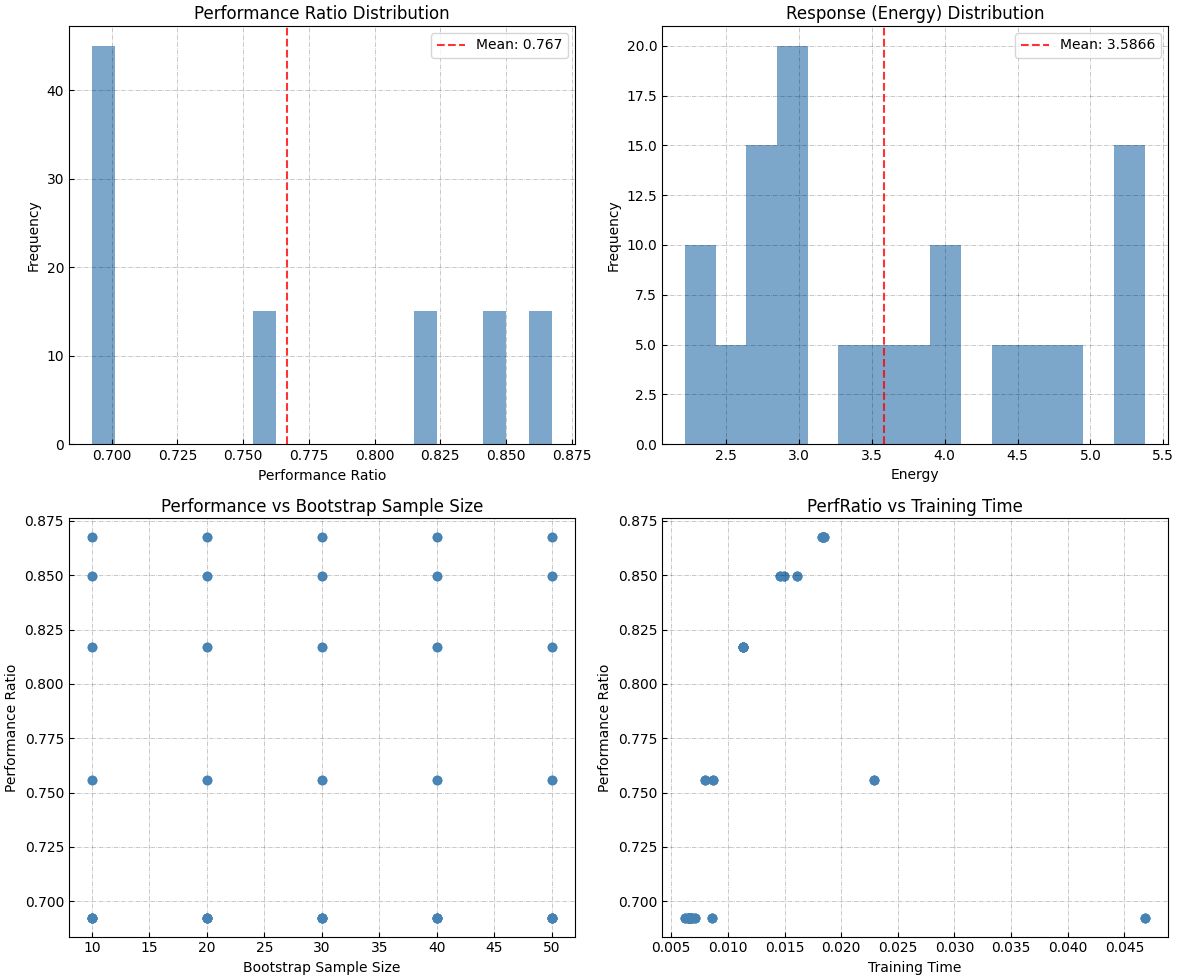


=== QAOA Analysis Summary ===
Mean Performance ratio: 0.7668
Mean Energy: 3.5866
Original QAOA parameters: gamma=0.649, beta=0.555

 Analysis completed successfully.


In [14]:
# === Simplified QAOA Analysis using Interpolated or Bootstrap Results ===
print("=== Simplified QAOA Analysis ===")

# Use interpolation results if available (includes fallback bootstrap results)
if hasattr(sb, 'interp_results') and sb.interp_results is not None and not sb.interp_results.empty:
    bs_data = sb.interp_results
    print("Analysis source: Interpolation or Bootstrap Fallback Data")
    print(f"Data shape: {bs_data.shape}")
    
    # === Sanity Check on Available Columns ===
    expected_cols = ['Key=PerfRatio', 'Key=Response', 'Key=MeanTime', 'boots']
    missing_cols = [col for col in expected_cols if col not in bs_data.columns]
    if missing_cols:
        print(f"\n Warning: Missing expected columns: {missing_cols}")
    else:
        print("\n All expected columns are available for analysis.")
    
    # === Metric Analysis ===
    metric_columns = [col for col in bs_data.columns if 'Key=' in col or 'ConfInt=' in col]
    if metric_columns:
        print(f"\nAvailable metrics: {metric_columns}")
        print(f"\nMetric Summary:")
        for col in metric_columns:
            if np.issubdtype(bs_data[col].dtype, np.number):
                print(f"{col}:")
                print(f"  Mean: {bs_data[col].mean():.4f}")
                print(f"  Std:  {bs_data[col].std():.4f}")
                print(f"  Min:  {bs_data[col].min():.4f}")
                print(f"  Max:  {bs_data[col].max():.4f}")
    else:
        print("\n No metric columns found for summary statistics.")
    
    # === Parameter Analysis ===
    param_cols = ['gamma', 'beta']
    available_params = [col for col in param_cols if col in bs_data.columns]
    
    if available_params:
        print(f"\nParameter Analysis (from bootstrap/interp data):")
        for param in available_params:
            if np.issubdtype(bs_data[param].dtype, np.number):
                param_range = bs_data[param].max() - bs_data[param].min()
                print(f"{param}: [{bs_data[param].min():.3f}, {bs_data[param].max():.3f}] (range: {param_range:.3f})")
    else:
        # Fallback to original QAOA data if available
        print(f"\nParameter Analysis (from original QAOA data):")
        if 'qaoa_df' in locals() and not qaoa_df.empty:
            for param in ['gamma', 'beta']:
                if param in qaoa_df.columns:
                    param_range = qaoa_df[param].max() - qaoa_df[param].min()
                    print(f"{param}: [{qaoa_df[param].min():.3f}, {qaoa_df[param].max():.3f}] (range: {param_range:.3f})")
    
    # === Instance Check ===
    n_unique_instances = bs_data.get('instance', pd.Series(['inst=1'])).nunique()
    print(f"\nInstance Analysis: {n_unique_instances} unique instance(s)")
    
    # === Performance Stability ===
    if 'Key=PerfRatio' in bs_data.columns:
        perf_std = bs_data['Key=PerfRatio'].std()
        mean_perf = bs_data['Key=PerfRatio'].mean()
        if mean_perf > 0:
            perf_cv = perf_std / mean_perf * 100
            print(f"Performance stability: CV = {perf_cv:.2f}%")
    else:
        print(" Skipping performance stability analysis (no PerfRatio column).")
    
    # === Visualization ===
    print("\nGenerating diagnostic plots...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plotted = False  # Track if at least one plot was drawn
    
    # Performance ratio distribution
    if 'Key=PerfRatio' in bs_data.columns:
        axes[0,0].hist(bs_data['Key=PerfRatio'], bins=min(20, len(bs_data)//2), alpha=0.7, color='steelblue')
        axes[0,0].set_title('Performance Ratio Distribution')
        axes[0,0].set_xlabel('Performance Ratio')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].grid(True, alpha=0.3)
        mean_perf = bs_data['Key=PerfRatio'].mean()
        axes[0,0].axvline(mean_perf, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_perf:.3f}')
        axes[0,0].legend()
        plotted = True
    
    # Response distribution
    if 'Key=Response' in bs_data.columns:
        axes[0,1].hist(bs_data['Key=Response'], bins=min(15, len(bs_data)//2), alpha=0.7, color='steelblue')
        axes[0,1].set_title('Response (Energy) Distribution')
        axes[0,1].set_xlabel('Energy')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].grid(True, alpha=0.3)
        mean_response = bs_data['Key=Response'].mean()
        axes[0,1].axvline(mean_response, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_response:.4f}')
        axes[0,1].legend()
        plotted = True
    
    # Bootstrap sample size effect
    if 'boots' in bs_data.columns and 'Key=PerfRatio' in bs_data.columns:
        axes[1,0].plot(bs_data['boots'], bs_data['Key=PerfRatio'], 'o', alpha=0.7, color='steelblue', markersize=6)
        axes[1,0].set_title('Performance vs Bootstrap Sample Size')
        axes[1,0].set_xlabel('Bootstrap Sample Size')
        axes[1,0].set_ylabel('Performance Ratio')
        axes[1,0].grid(True, alpha=0.3)
        plotted = True
    
    # Time vs Response
    if 'Key=PerfRatio' in bs_data.columns and 'Key=MeanTime' in bs_data.columns:
        axes[1,1].scatter(bs_data['Key=MeanTime'], bs_data['Key=PerfRatio'], alpha=0.7, color='steelblue')
        axes[1,1].set_title('PerfRatio vs Training Time')
        axes[1,1].set_xlabel('Training Time')
        axes[1,1].set_ylabel('Performance Ratio')
        axes[1,1].grid(True, alpha=0.3)
        plotted = True
    
    plt.tight_layout()
    if plotted:
        plt.show()
    else:
        plt.close()
        print(" No plots generated — required columns missing.")
    
    # === Summary ===
    print(f"\n=== QAOA Analysis Summary ===")
    if 'Key=PerfRatio' in bs_data.columns:
        print(f"Mean Performance ratio: {bs_data['Key=PerfRatio'].mean():.4f}")
    if 'Key=Response' in bs_data.columns:
        print(f"Mean Energy: {bs_data['Key=Response'].mean():.4f}")
    if 'qaoa_df' in locals() and not qaoa_df.empty:
        print(f"Original QAOA parameters: gamma={qaoa_df['gamma'].iloc[0]:.3f}, beta={qaoa_df['beta'].iloc[0]:.3f}")
    
    print("\n Analysis completed successfully.")

else:
    print(" No interpolation or bootstrap results available — cannot perform QAOA analysis.")


In [15]:
# === Check if we should run statistics analysis for single instance ===
if hasattr(sb, 'interp_results') and sb.interp_results is not None and not sb.interp_results.empty:
    n_rows = len(sb.interp_results)
    print(f"Data available for statistics: {n_rows} rows")
    
    # Detect single instance scenario
    n_unique_instances = sb.interp_results.get('instance', pd.Series(['inst=1'])).nunique()
    
    if n_unique_instances == 1 or n_rows <= 5:
        print("\nSingle instance detected - statistics analysis provides limited value")
        print("Skipping statistics analysis for single instance case")
        print("Reason: Insufficient data for meaningful train/test split or only one instance available")
        
        # Set empty results to indicate statistics was skipped
        sb.stat_results = None
        print("Statistics analysis skipped")
        
    else:
        # Multiple instances - run full statistics
        print("\nMultiple instances detected - running statistics analysis")
        
        # Set up statistics parameters
        train_test_split = 0.8
        metrics = ['Key=Response', 'Key=PerfRatio', 'Key=SuccProb', 'Key=MeanTime'] # RTT, 'InvPerfRatio'
        stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
        
        # Disable split validity check to avoid warnings
        original_check = getattr(training, 'check_split_validity', True)
        training.check_split_validity = False
        
        try:
            sb.run_Stats(stParams, train_test_split)
            print("Statistics analysis completed")
            
            if hasattr(sb, 'stat_results') and sb.stat_results is not None:
                print(f"Statistics results shape: {sb.stat_results.shape}")
                print("Sample statistics results:")
                display(sb.stat_results.head())
            else:
                print("No statistics results available")
                
        except Exception as e:
            print(f"Statistics analysis failed: {e}")
            import traceback
            traceback.print_exc()
        finally:
            # Restore original setting
            training.check_split_validity = original_check
            
else:
    print("No interpolation or bootstrap fallback results available - cannot run statistics analysis")


Data available for statistics: 105 rows

Multiple instances detected - running statistics analysis
Statistics analysis completed
No statistics results available


In [16]:
# Check if we should run baseline analysis for single instance
if hasattr(sb, 'interp_results') and sb.interp_results is not None:
    n_rows = len(sb.interp_results)
    print(f"Data available for baseline analysis: {n_rows} rows")
    
    # Check if this is single instance by looking at original data
    is_single_instance = len(all_qaoa_df) == 1 if 'all_qaoa_df' in locals() else n_rows <= 5
    
    if is_single_instance:
        print("Single instance detected - baseline analysis provides limited value")
        print("Skipping baseline analysis for single instance case")
        print("Reason: Baseline comparison requires multiple instances or parameter configurations")
        
        # Set baseline to None to indicate it was appropriately skipped
        sb.baseline = None
        print("Baseline analysis skipped")
        
    else:
        # Multiple instances - run baseline analysis
        print("Multiple instances detected - running baseline analysis")
        
        # Check if train column exists, add if missing
        if 'train' not in sb.interp_results.columns:
            print("Adding train/test split column for baseline analysis...")
            np.random.seed(42)
            train_mask = np.random.random(len(sb.interp_results)) < 0.8
            sb.interp_results['train'] = train_mask.astype(int)
        
        try:
            sb.run_baseline()
            print("Baseline analysis completed")
            
            # Evaluate baseline
            if hasattr(sb, 'baseline') and sb.baseline is not None:
                recipes, _ = sb.baseline.evaluate()
                print(f"Baseline recipes shape: {recipes.shape}")
                print("\nBaseline recipe sample:")
                display(recipes.head())
            else:
                print("No baseline results available")
                
        except Exception as e:
            print(f"Baseline analysis failed: {e}")
            print("This may be due to insufficient data for meaningful baseline comparison")
            import traceback
            traceback.print_exc()
            
else:
    print("No interpolation results available - cannot run baseline analysis")

Data available for baseline analysis: 105 rows
Multiple instances detected - running baseline analysis
Baseline analysis completed


100%|██████████| 14/14 [00:00<00:00, 449.84it/s]

Baseline recipes shape: (14, 3)

Baseline recipe sample:


,gamma,beta,circuit_depth
resource,,,
0.006544,0.392672,0.615534,1.0
0.006569,0.392672,0.615534,1.0
0.006868,0.392672,0.615534,1.0
0.007130,0.392672,0.615534,1.0
0.007992,0.555060,0.292508,2.0



=== QAOA Stochastic Benchmark Analysis Summary ===


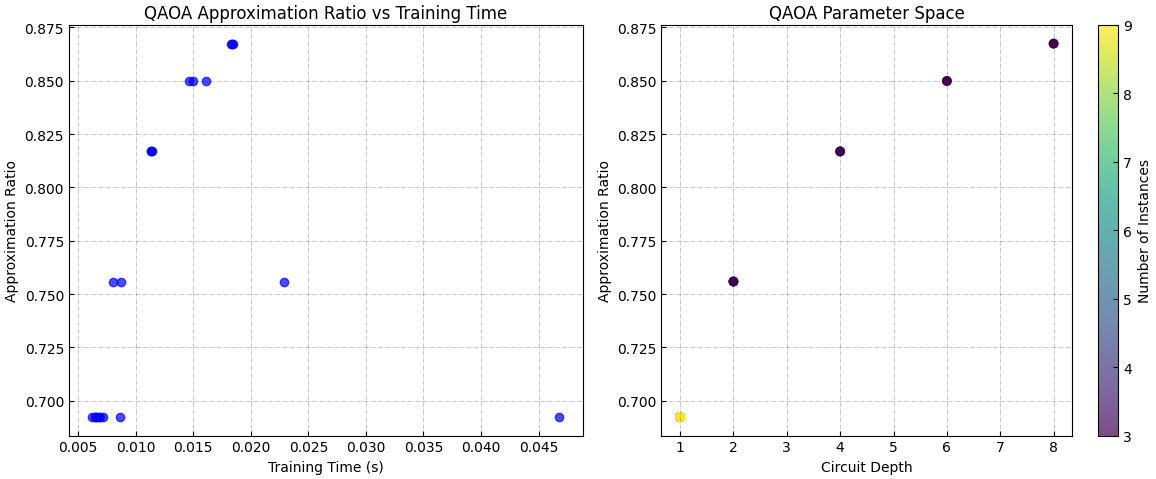


Original Data Summary:
Processed 21 QAOA optimization trials
Parameter space: Gamma [0.393, 0.649], Beta [0.293, 0.616] Circuit Depths: [2 4 6 8 1]
Approximation Ratio range: [0.6925, 0.8674]
Training time range: [0.0062, 0.0468] seconds

=== Analysis Components Status ===
Bootstrap: COMPLETED (105 results)
Interpolation: COMPLETED (105 results)
Statistics: FAILED
Baseline: COMPLETED

=== Overall Status ===
Completed components: Bootstrap, Interpolation, Baseline
Failed components: Statistics
Analysis completion rate: 75% (3/4 applicable components)

Completed analysis components: 3


In [17]:
# === Final Analysis Summary and Status Report ===
print("\n=== QAOA Stochastic Benchmark Analysis Summary ===")

# Original data visualization
if 'agg_df' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # PerfRatio vs training time
    valid_data = agg_df[agg_df['Approximation_Ratio'] != -999]
    if len(valid_data) > 0:
        ax1.scatter(valid_data['MeanTime'], valid_data['Approximation_Ratio'], alpha=0.7, color='blue')
        ax1.set_xlabel('Training Time (s)')
        ax1.set_ylabel('Approximation Ratio')
        ax1.set_title('QAOA Approximation Ratio vs Training Time')
        ax1.grid(True, alpha=0.3)
    
    # Parameter space visualization
    if 'circuit_depth' in agg_df.columns and 'Approximation_Ratio' in agg_df.columns and len(valid_data) > 0:
        scatter = ax2.scatter(valid_data['circuit_depth'], valid_data['Approximation_Ratio'],
                             c=valid_data['Approximation_Ratio'], alpha=0.7)
        ax2.set_xlabel('Circuit Depth')
        ax2.set_ylabel('Approximation Ratio')
        ax2.set_title('QAOA Parameter Space')
        ax2.grid(True, alpha=0.3)
        # Plot number of instances on colorbar for each depth
        num_instances = valid_data['circuit_depth'].value_counts()
        scatter = ax2.scatter(valid_data['circuit_depth'], valid_data['Approximation_Ratio'],
                             c=num_instances[valid_data['circuit_depth']].values, alpha=0.7)
        plt.colorbar(scatter, ax=ax2, label='Number of Instances')
    plt.tight_layout()
    plt.show()
    
    # Data summary
    print(f"\nOriginal Data Summary:")
    print(f"Processed {len(all_qaoa_results)} QAOA optimization trials")
    if len(valid_data) > 0:
        print(f"Parameter space: Gamma [{valid_data['gamma'].min():.3f}, {valid_data['gamma'].max():.3f}], "
              f"Beta [{valid_data['beta'].min():.3f}, {valid_data['beta'].max():.3f}]", f"Circuit Depths: {valid_data['circuit_depth'].unique()}")
        print(f"Approximation Ratio range: [{valid_data['Approximation_Ratio'].min():.4f}, {valid_data['Approximation_Ratio'].max():.4f}]")
        print(f"Training time range: [{valid_data['MeanTime'].min():.4f}, {valid_data['MeanTime'].max():.4f}] seconds")

# === Analysis Components Status ===
print(f"\n=== Analysis Components Status ===")
completed_components = []
skipped_components = []
failed_components = []

# Bootstrap
if hasattr(sb, 'bs_results') and sb.bs_results is not None:
    completed_components.append('Bootstrap')
    print(f"Bootstrap: COMPLETED ({sb.bs_results.shape[0]} results)")
else:
    failed_components.append('Bootstrap')
    print("Bootstrap: FAILED")

# Interpolation
if hasattr(sb, 'interp_results') and sb.interp_results is not None:
    completed_components.append('Interpolation')
    print(f"Interpolation: COMPLETED ({sb.interp_results.shape[0]} results)")
else:
    failed_components.append('Interpolation')
    print("Interpolation: FAILED")

# Statistics
if hasattr(sb, 'stat_results'):
    if sb.stat_results is not None:
        completed_components.append('Statistics')
        print(f"Statistics: COMPLETED ({sb.stat_results.shape[0]} results)")
    else:
        skipped_components.append('Statistics')
        print("Statistics: SKIPPED (single instance or insufficient data)")
else:
    failed_components.append('Statistics')
    print("Statistics: FAILED")

# Baseline
if hasattr(sb, 'baseline') and sb.baseline is not None:
    completed_components.append('Baseline')
    print("Baseline: COMPLETED")
else:
    # Check if baseline was skipped for single instance
    if ('qaoa_results' in locals() and len(qaoa_results) == 1) or \
       (hasattr(sb, 'interp_results') and len(sb.interp_results) <= 5):
        skipped_components.append('Baseline')
        print("Baseline: SKIPPED (single instance, limited baseline value)")
    else:
        failed_components.append('Baseline')
        print("Baseline: FAILED")

# Overall status
print(f"\n=== Overall Status ===")
total_components = 4
actual_completed = len(completed_components)
actual_attempted = total_components - len(skipped_components)

print(f"Completed components: {', '.join(completed_components) if completed_components else 'None'}")
if skipped_components:
    print(f"Skipped components: {', '.join(skipped_components)} (appropriate for single instance)")
if failed_components:
    print(f"Failed components: {', '.join(failed_components)}")

# Adjusted completion rate
if actual_attempted > 0:
    completion_rate = actual_completed / actual_attempted * 100
    print(f"Analysis completion rate: {completion_rate:.0f}% ({actual_completed}/{actual_attempted} applicable components)")
else:
    print("No applicable components for analysis")

# Results summary
if completed_components:
    print(f"\nCompleted analysis components: {len(completed_components)}")
else:
    print("\nNo analysis components completed successfully")
